In [1]:
import torch
import numpy as np
from torch.utils import data
from torch.nn import init
from matplotlib import pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [4]:
#加载数据集
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True,
download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False,
download=True, transform=transforms.ToTensor())

#定义训练参数
batch_size, num_epochs, lr = 64, 100, 0.1

#划分数据集
temp = []
for i in range(1000):
    temp.append(list(mnist_train[i]))
train_iter = torch.utils.data.DataLoader(temp, batch_size=batch_size, shuffle=True,num_workers=0)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=0)

#定义模型参数
num_inputs, num_outputs, num_hiddens = 784, 10, 256

#定义损失函数
loss = torch.nn.CrossEntropyLoss()

#定义丢弃函数
def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()
    return mask * X / keep_prob

#定义linear层函数
def linear(X, w, b):
    return torch.matmul(X, w.t())+ b

#定义隐藏层激活函数
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

#定义分类模型
def net(X, drop_prob, is_training=True):
    X = X.view((-1, num_inputs))          
    linear_1 = linear(X, W1, b1)
    H1 = relu(linear_1)            #第一层隐藏层
    if is_training:
        H1 = dropout(H1, drop_prob)
    linear_2 = linear(H1, W2, b2)
    H2 = relu(linear_2)
    if is_training:
        H2 = dropout(H2, drop_prob)
    linear_3 = linear(H2, W3, b3)
    return linear_3

#定义随机梯度下降函数
def SGD(params, lr):
    for param in params:
        param.data -= lr * param.grad
        
#定义计算测试集损失函数
def evaluate_loss(data_iter, net):
    l, n = 0.0, 0
    for X, y in data_iter:
        l += loss(net(X, 0.0, is_training=False),y).sum().item()
        n += y.shape[0]
    return l / n

#定义计算测试集准确率函数
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        X = X.view((-1, num_inputs)) 
        acc_sum += (net(X, 0.0, is_training=False).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [5]:
# ==================== 无丢弃率 ==================== #

#定义惩罚权重
drop_prob0 = 0.0

#定义随机初始化模型参数的函数
W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_hiddens)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, dtype=torch.float, requires_grad=True)
params = [W1, b1, W2, b2, W3, b3]

#训练模型
loss_train0 = []
loss_test0 = []
acc_train0 = []
acc_test0 = []
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        y_hat = net(X, drop_prob0, is_training=True)
        l = loss(y_hat,y).sum() 
        l.backward()          #计算损失     
        SGD(params, lr)       #更新梯度
        W1.grad.data.zero_()  #梯度清零
        b1.grad.data.zero_()
        W2.grad.data.zero_()
        b2.grad.data.zero_()
        W3.grad.data.zero_()
        b3.grad.data.zero_()
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    loss_train0.append(train_l_sum/n)
    loss_test0.append(evaluate_loss(test_iter,net))
    acc_train0.append(train_acc_sum/n)
    acc_test0.append(evaluate_accuracy(test_iter,net))
    print('epoch %d, loss_train %f, loss_test %f , acc_train %f, acc_test %f '% 
          (epoch+1, loss_train0[epoch], loss_test0[epoch], acc_train0[epoch], acc_test0[epoch]))

epoch 1, loss_train 0.036832, loss_test 0.036122 , acc_train 0.118000, acc_test 0.170600 
epoch 2, loss_train 0.036786, loss_test 0.036079 , acc_train 0.166000, acc_test 0.168900 
epoch 3, loss_train 0.036708, loss_test 0.035981 , acc_train 0.200000, acc_test 0.189600 
epoch 4, loss_train 0.036530, loss_test 0.035685 , acc_train 0.230000, acc_test 0.198500 
epoch 5, loss_train 0.035933, loss_test 0.034596 , acc_train 0.239000, acc_test 0.197700 
epoch 6, loss_train 0.034173, loss_test 0.032144 , acc_train 0.234000, acc_test 0.269400 
epoch 7, loss_train 0.030877, loss_test 0.027678 , acc_train 0.340000, acc_test 0.297200 
epoch 8, loss_train 0.026124, loss_test 0.024067 , acc_train 0.362000, acc_test 0.434800 
epoch 9, loss_train 0.022899, loss_test 0.022589 , acc_train 0.463000, acc_test 0.371200 
epoch 10, loss_train 0.021827, loss_test 0.020236 , acc_train 0.456000, acc_test 0.487200 
epoch 11, loss_train 0.020723, loss_test 0.019445 , acc_train 0.487000, acc_test 0.489400 
epoch 12

epoch 92, loss_train 0.002723, loss_test 0.012543 , acc_train 0.937000, acc_test 0.773000 
epoch 93, loss_train 0.002718, loss_test 0.011929 , acc_train 0.944000, acc_test 0.779900 
epoch 94, loss_train 0.002515, loss_test 0.011984 , acc_train 0.948000, acc_test 0.782200 
epoch 95, loss_train 0.002288, loss_test 0.011447 , acc_train 0.951000, acc_test 0.790700 
epoch 96, loss_train 0.002404, loss_test 0.011875 , acc_train 0.949000, acc_test 0.788800 
epoch 97, loss_train 0.001976, loss_test 0.013013 , acc_train 0.963000, acc_test 0.780200 
epoch 98, loss_train 0.003319, loss_test 0.019734 , acc_train 0.930000, acc_test 0.693900 
epoch 99, loss_train 0.003201, loss_test 0.012069 , acc_train 0.938000, acc_test 0.777800 
epoch 100, loss_train 0.001996, loss_test 0.011840 , acc_train 0.967000, acc_test 0.789800 


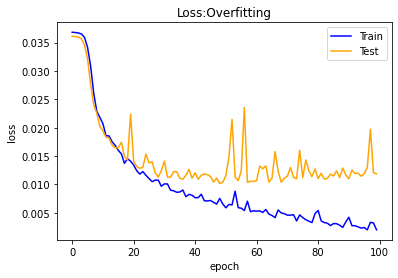

In [15]:
#plt.figure(figsize=(10,7))
plt.plot(loss_train0,label='Train',color='blue')
plt.plot(loss_test0,label='Test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Loss:Overfitting")
plt.legend()
plt.show()

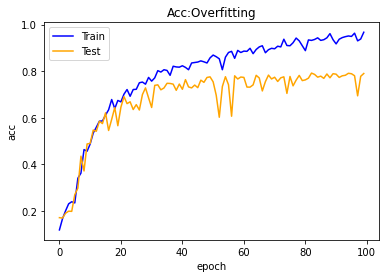

In [16]:
#plt.figure(figsize=(10,7))
plt.plot(acc_train0,label='Train',color='blue')
plt.plot(acc_test0,label='Test', color='orange')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Acc:Overfitting")
plt.legend()
plt.show()

In [10]:
# ========== 丢弃率为0.2 ==========

#定义丢弃率
drop_prob1 = 0.2

#定义随机初始化模型参数的函数
W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_hiddens)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, dtype=torch.float, requires_grad=True)
params = [W1, b1, W2, b2, W3, b3]

#训练模型
loss_train1 = []
loss_test1 = []
acc_train1 = []
acc_test1 = []
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        y_hat = net(X, drop_prob1, is_training=True)
        l = loss(y_hat,y).sum() 
        l.backward()          #计算损失     
        SGD(params, lr)       #更新梯度
        W1.grad.data.zero_()  #梯度清零
        b1.grad.data.zero_()
        W2.grad.data.zero_()
        b2.grad.data.zero_()
        W3.grad.data.zero_()
        b3.grad.data.zero_()
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    loss_train1.append(train_l_sum/n)
    loss_test1.append(evaluate_loss(test_iter,net))
    acc_train1.append(train_acc_sum/n)
    acc_test1.append(evaluate_accuracy(test_iter,net))
    print('epoch %d, loss_train %f, loss_test %f , acc_train %f, acc_test %f '% 
          (epoch+1, loss_train1[epoch], loss_test1[epoch], acc_train1[epoch], acc_test1[epoch]))

epoch 1, loss_train 0.036835, loss_test 0.036123 , acc_train 0.115000, acc_test 0.100000 
epoch 2, loss_train 0.036789, loss_test 0.036080 , acc_train 0.158000, acc_test 0.118600 
epoch 3, loss_train 0.036718, loss_test 0.035989 , acc_train 0.162000, acc_test 0.180900 
epoch 4, loss_train 0.036544, loss_test 0.035709 , acc_train 0.213000, acc_test 0.196500 
epoch 5, loss_train 0.035953, loss_test 0.034590 , acc_train 0.221000, acc_test 0.199800 
epoch 6, loss_train 0.034030, loss_test 0.031706 , acc_train 0.236000, acc_test 0.249500 
epoch 7, loss_train 0.030170, loss_test 0.027013 , acc_train 0.302000, acc_test 0.411000 
epoch 8, loss_train 0.026163, loss_test 0.023758 , acc_train 0.374000, acc_test 0.367900 
epoch 9, loss_train 0.023471, loss_test 0.022675 , acc_train 0.369000, acc_test 0.308400 
epoch 10, loss_train 0.022270, loss_test 0.023477 , acc_train 0.408000, acc_test 0.472800 
epoch 11, loss_train 0.021762, loss_test 0.019991 , acc_train 0.468000, acc_test 0.446500 
epoch 12

epoch 92, loss_train 0.002895, loss_test 0.012731 , acc_train 0.946000, acc_test 0.759500 
epoch 93, loss_train 0.003088, loss_test 0.011366 , acc_train 0.942000, acc_test 0.787400 
epoch 94, loss_train 0.002959, loss_test 0.011370 , acc_train 0.943000, acc_test 0.788500 
epoch 95, loss_train 0.002988, loss_test 0.012072 , acc_train 0.939000, acc_test 0.786300 
epoch 96, loss_train 0.002855, loss_test 0.011406 , acc_train 0.932000, acc_test 0.789600 
epoch 97, loss_train 0.002894, loss_test 0.011030 , acc_train 0.943000, acc_test 0.793000 
epoch 98, loss_train 0.003237, loss_test 0.012101 , acc_train 0.933000, acc_test 0.772600 
epoch 99, loss_train 0.002294, loss_test 0.011744 , acc_train 0.959000, acc_test 0.787300 
epoch 100, loss_train 0.002512, loss_test 0.011869 , acc_train 0.951000, acc_test 0.779500 


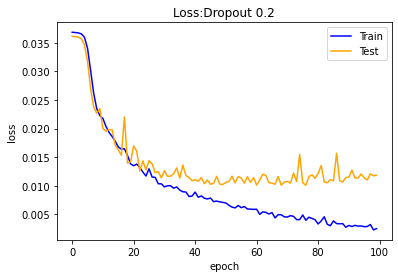

In [18]:
#plt.figure(figsize=(10,7))
plt.plot(loss_train1,label='Train',color='blue')
plt.plot(loss_test1,label='Test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Loss:Dropout 0.2")
plt.legend()
plt.show()

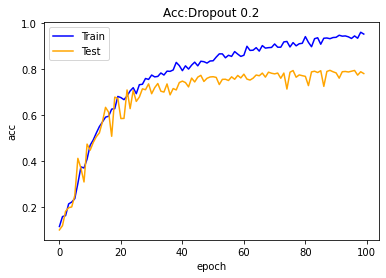

In [17]:
#plt.figure(figsize=(10,7))
plt.plot(acc_train1,label='Train',color='blue')
plt.plot(acc_test1,label='Test', color='orange')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Acc:Dropout 0.2")
plt.legend()
plt.show()

In [11]:
# ========== 丢弃率为0.5 ==========

#定义丢弃率
drop_prob2 = 0.5

#定义随机初始化模型参数的函数
W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_hiddens)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, dtype=torch.float, requires_grad=True)
params = [W1, b1, W2, b2, W3, b3]

#训练模型
loss_train2 = []
loss_test2 = []
acc_train2 = []
acc_test2 = []
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        y_hat = net(X, drop_prob2, is_training=True)
        l = loss(y_hat,y).sum() 
        l.backward()          #计算损失     
        SGD(params, lr)       #更新梯度
        W1.grad.data.zero_()  #梯度清零
        b1.grad.data.zero_()
        W2.grad.data.zero_()
        b2.grad.data.zero_()
        W3.grad.data.zero_()
        b3.grad.data.zero_()
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    loss_train2.append(train_l_sum/n)
    loss_test2.append(evaluate_loss(test_iter,net))
    acc_train2.append(train_acc_sum/n)
    acc_test2.append(evaluate_accuracy(test_iter,net))
    print('epoch %d, loss_train %f, loss_test %f , acc_train %f, acc_test %f '% 
          (epoch+1, loss_train2[epoch], loss_test2[epoch], acc_train2[epoch], acc_test2[epoch]))

epoch 1, loss_train 0.036838, loss_test 0.036131 , acc_train 0.102000, acc_test 0.100000 
epoch 2, loss_train 0.036801, loss_test 0.036097 , acc_train 0.151000, acc_test 0.100300 
epoch 3, loss_train 0.036746, loss_test 0.036033 , acc_train 0.143000, acc_test 0.164200 
epoch 4, loss_train 0.036636, loss_test 0.035866 , acc_train 0.188000, acc_test 0.189700 
epoch 5, loss_train 0.036326, loss_test 0.035286 , acc_train 0.209000, acc_test 0.199200 
epoch 6, loss_train 0.035242, loss_test 0.033383 , acc_train 0.231000, acc_test 0.203200 
epoch 7, loss_train 0.032620, loss_test 0.029763 , acc_train 0.268000, acc_test 0.319000 
epoch 8, loss_train 0.028582, loss_test 0.025739 , acc_train 0.310000, acc_test 0.363800 
epoch 9, loss_train 0.025838, loss_test 0.023474 , acc_train 0.336000, acc_test 0.340300 
epoch 10, loss_train 0.023665, loss_test 0.022147 , acc_train 0.373000, acc_test 0.438800 
epoch 11, loss_train 0.022407, loss_test 0.021265 , acc_train 0.414000, acc_test 0.510100 
epoch 12

epoch 92, loss_train 0.003929, loss_test 0.010375 , acc_train 0.914000, acc_test 0.791000 
epoch 93, loss_train 0.004198, loss_test 0.010398 , acc_train 0.909000, acc_test 0.790200 
epoch 94, loss_train 0.004463, loss_test 0.010189 , acc_train 0.905000, acc_test 0.798600 
epoch 95, loss_train 0.003951, loss_test 0.010427 , acc_train 0.905000, acc_test 0.791500 
epoch 96, loss_train 0.004021, loss_test 0.010099 , acc_train 0.923000, acc_test 0.795400 
epoch 97, loss_train 0.003748, loss_test 0.010816 , acc_train 0.925000, acc_test 0.792000 
epoch 98, loss_train 0.003380, loss_test 0.010227 , acc_train 0.923000, acc_test 0.800300 
epoch 99, loss_train 0.003459, loss_test 0.014664 , acc_train 0.932000, acc_test 0.714400 
epoch 100, loss_train 0.003923, loss_test 0.011528 , acc_train 0.920000, acc_test 0.774800 


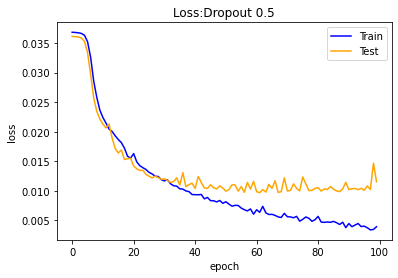

In [19]:
#plt.figure(figsize=(10,7))
plt.plot(loss_train2,label='Train',color='blue')
plt.plot(loss_test2,label='Test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Loss:Dropout 0.5")
plt.legend()
plt.show()

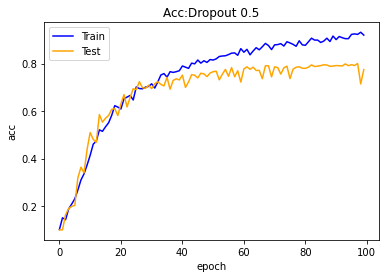

In [20]:
#plt.figure(figsize=(10,7))
plt.plot(acc_train2,label='Train',color='blue')
plt.plot(acc_test2,label='Test', color='orange')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Acc:Dropout 0.5")
plt.legend()
plt.show()

In [12]:
# ========== 丢弃率为0.7 ==========

#定义丢弃率
drop_prob3 = 0.7

#定义随机初始化模型参数的函数
W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_hiddens)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, dtype=torch.float, requires_grad=True)
params = [W1, b1, W2, b2, W3, b3]

#训练模型
loss_train3 = []
loss_test3 = []
acc_train3 = []
acc_test3 = []
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        y_hat = net(X, drop_prob3, is_training=True)
        l = loss(y_hat,y).sum() 
        l.backward()          #计算损失     
        SGD(params, lr)       #更新梯度
        W1.grad.data.zero_()  #梯度清零
        b1.grad.data.zero_()
        W2.grad.data.zero_()
        b2.grad.data.zero_()
        W3.grad.data.zero_()
        b3.grad.data.zero_()
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    loss_train3.append(train_l_sum/n)
    loss_test3.append(evaluate_loss(test_iter,net))
    acc_train3.append(train_acc_sum/n)
    acc_test3.append(evaluate_accuracy(test_iter,net))
    print('epoch %d, loss_train %f, loss_test %f , acc_train %f, acc_test %f '% 
          (epoch+1, loss_train3[epoch], loss_test3[epoch], acc_train3[epoch], acc_test3[epoch]))

epoch 1, loss_train 0.036830, loss_test 0.036127 , acc_train 0.116000, acc_test 0.101400 
epoch 2, loss_train 0.036802, loss_test 0.036097 , acc_train 0.132000, acc_test 0.155400 
epoch 3, loss_train 0.036756, loss_test 0.036040 , acc_train 0.166000, acc_test 0.177900 
epoch 4, loss_train 0.036651, loss_test 0.035886 , acc_train 0.192000, acc_test 0.193400 
epoch 5, loss_train 0.036376, loss_test 0.035399 , acc_train 0.187000, acc_test 0.186800 
epoch 6, loss_train 0.035585, loss_test 0.034055 , acc_train 0.198000, acc_test 0.229500 
epoch 7, loss_train 0.033984, loss_test 0.032106 , acc_train 0.251000, acc_test 0.287300 
epoch 8, loss_train 0.031802, loss_test 0.028736 , acc_train 0.320000, acc_test 0.433400 
epoch 9, loss_train 0.028820, loss_test 0.025320 , acc_train 0.306000, acc_test 0.447100 
epoch 10, loss_train 0.026420, loss_test 0.022780 , acc_train 0.345000, acc_test 0.414200 
epoch 11, loss_train 0.024625, loss_test 0.021576 , acc_train 0.389000, acc_test 0.415700 
epoch 12

epoch 92, loss_train 0.006974, loss_test 0.010377 , acc_train 0.834000, acc_test 0.780800 
epoch 93, loss_train 0.006159, loss_test 0.009955 , acc_train 0.867000, acc_test 0.791100 
epoch 94, loss_train 0.006059, loss_test 0.010826 , acc_train 0.856000, acc_test 0.771800 
epoch 95, loss_train 0.006405, loss_test 0.010045 , acc_train 0.847000, acc_test 0.787000 
epoch 96, loss_train 0.006328, loss_test 0.010108 , acc_train 0.864000, acc_test 0.790900 
epoch 97, loss_train 0.005872, loss_test 0.010622 , acc_train 0.869000, acc_test 0.774700 
epoch 98, loss_train 0.006291, loss_test 0.010002 , acc_train 0.862000, acc_test 0.790800 
epoch 99, loss_train 0.006024, loss_test 0.010493 , acc_train 0.875000, acc_test 0.783100 
epoch 100, loss_train 0.006042, loss_test 0.010379 , acc_train 0.864000, acc_test 0.783600 


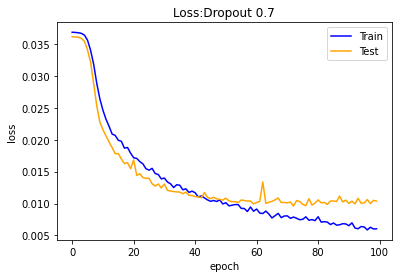

In [21]:
#plt.figure(figsize=(10,7))
plt.plot(loss_train3,label='Train',color='blue')
plt.plot(loss_test3,label='Test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Loss:Dropout 0.7")
plt.legend()
plt.show()

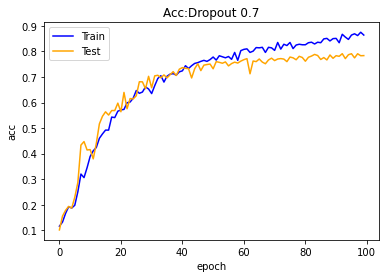

In [22]:
#plt.figure(figsize=(10,7))
plt.plot(acc_train3,label='Train',color='blue')
plt.plot(acc_test3,label='Test', color='orange')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Acc:Dropout 0.7")
plt.legend()
plt.show()

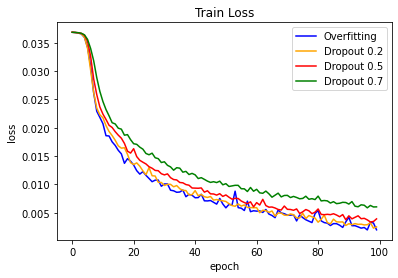

In [23]:
#plt.figure(figsize=(10,7))
plt.plot(loss_train0,label='Overfitting',color='blue')
plt.plot(loss_train1,label='Dropout 0.2', color='orange')
plt.plot(loss_train2,label='Dropout 0.5', color='red')
plt.plot(loss_train3,label='Dropout 0.7', color='green')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Train Loss")
plt.legend()
plt.show()

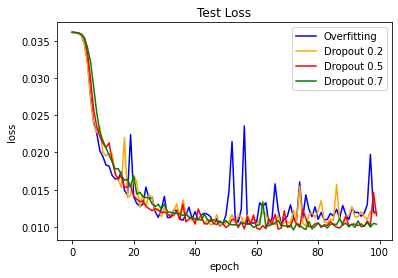

In [24]:
#plt.figure(figsize=(10,7))
plt.plot(loss_test0,label='Overfitting',color='blue')
plt.plot(loss_test1,label='Dropout 0.2', color='orange')
plt.plot(loss_test2,label='Dropout 0.5', color='red')
plt.plot(loss_test3,label='Dropout 0.7', color='green')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Test Loss")
plt.legend()
plt.show()

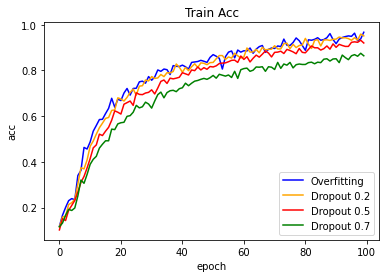

In [25]:
#plt.figure(figsize=(10,7))
plt.plot(acc_train0,label='Overfitting',color='blue')
plt.plot(acc_train1,label='Dropout 0.2', color='orange')
plt.plot(acc_train2,label='Dropout 0.5', color='red')
plt.plot(acc_train3,label='Dropout 0.7', color='green')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Train Acc")
plt.legend()
plt.show()

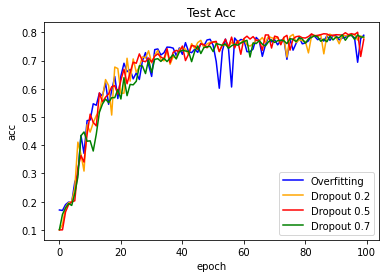

In [26]:
#plt.figure(figsize=(10,7))
plt.plot(acc_test0,label='Overfitting',color='blue')
plt.plot(acc_test1,label='Dropout 0.2', color='orange')
plt.plot(acc_test2,label='Dropout 0.5', color='red')
plt.plot(acc_test3,label='Dropout 0.7', color='green')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Test Acc")
plt.legend()
plt.show()